### Документация для учебного блока по Advantage-функциям и MCTS

Этот учебный блок демонстрирует использование Advantage-функций в обучении с подкреплением (Reinforcement Learning, RL) и строит дерево поиска Монте-Карло (MCTS) для визуализации процесса принятия решений.



In [14]:
# Импорты библиотек
# -----------------------------------------------------------------------------
# Стандартные библиотеки
import random
import math
import time
import copy
from typing import Optional, List, Dict, Tuple
from collections import deque, namedtuple

# Внешние библиотеки
import gym
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import MultivariateNormal, Normal

In [15]:
class APN(nn.Module):
    """
    Description:
    ---------------
        Класс APN (Advantage Policy Network) для модели нейронной сети.

    Args:
    ---------------
        state_size: Размер состояния.
        action_size: Размер действия.
        layer_size: Размер слоя.
        seed: Зерно для инициализации генератора случайных чисел.

    Returns:
    ---------------
        None

    Raises:
    ---------------
        None

    Examples:
    ---------------
        >>> model = APN(state_size=10, action_size=4, layer_size=64, seed=42)
    """

    def __init__(self, state_size: int, action_size: int,
                 layer_size: int, seed: int):
        super(APN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size

        self.head_1 = nn.Linear(self.input_shape, layer_size)
        self.bn1 = nn.BatchNorm1d(layer_size)
        self.ff_1 = nn.Linear(layer_size, layer_size)
        self.bn2 = nn.BatchNorm1d(layer_size)
        self.action_values = nn.Linear(layer_size, action_size)
        self.value = nn.Linear(layer_size, 1)
        self.matrix_entries = nn.Linear(
            layer_size, int(self.action_size * (self.action_size + 1) / 2)
        )

    def forward(self, input_data: torch.Tensor,
                action: Optional[torch.Tensor] = None
                ) -> Tuple[torch.Tensor, Optional[torch.Tensor], torch.Tensor]:
        """
        Description:
        ---------------
            Выполняет прямой проход через сеть.

        Args:
        ---------------
            input_data: Входные данные.
            action: Действие (опционально).

        Returns:
        ---------------
            action: Выходное действие.
            Q: Значение Q-функции (если действие передано).
            V: Значение V-функции.

        Raises:
        ---------------
            None

        Examples:
        ---------------
            >>> model = APN(state_size=10, action_size=4, layer_size=64, seed=42)
            >>> action, Q, V = model(torch.randn(1, 10))
        """
        x = torch.relu(self.head_1(input_data))
        x = torch.relu(self.ff_1(x))
        action_value = torch.tanh(self.action_values(x))
        entries = torch.tanh(self.matrix_entries(x))
        V = self.value(x)

        action_value = action_value.unsqueeze(-1)

        # Создание нижней треугольной матрицы
        L = torch.zeros((input_data.shape[0], self.action_size,
                         self.action_size)).to(input_data.device)

        # Получение индексов нижней треугольной матрицы
        tril_indices = torch.tril_indices(row=self.action_size,
                                          col=self.action_size, offset=0)

        # Заполнение матрицы значениями
        L[:, tril_indices[0], tril_indices[1]] = entries
        L.diagonal(dim1=1, dim2=2).exp_()

        # Вычисление состояния зависимой положительно определенной квадратной матрицы
        P = L * L.transpose(2, 1)

        Q = None
        if action is not None:
            # Вычисление Advantage
            A = (-0.5 * torch.matmul(
                torch.matmul((action.unsqueeze(-1) - action_value).transpose(2, 1), P),
                (action.unsqueeze(-1) - action_value)
            )).squeeze(-1)

            Q = A + V

        # Добавление шума к действию
        dist = MultivariateNormal(action_value.squeeze(-1), torch.inverse(P))
        action = dist.sample()
        action = torch.clamp(action, min=-1, max=1)

        return action, Q, V


    def get_advantage(self, state: torch.Tensor, actions: torch.Tensor) -> torch.Tensor:
        """
        Description:
        ---------------
            Вычисляет Advantage для всех переданных действий.

        Args:
        ---------------
            state: Тензор, представляющий состояние.
            actions: Тензор, представляющий действия.

        Returns:
        ---------------
            advantage: Тензор, представляющий Advantage для каждого действия.

        Raises:
        ---------------
            None

        Examples:
        ---------------
            >>> model = APN(state_size=10, action_size=4, layer_size=64, seed=42)
            >>> state = torch.randn(1, 10)
            >>> actions = torch.randn(1, 4)
            >>> advantage = model.get_advantage(state, actions)
        """
        # Выполняем прямой проход через сеть для получения Q и V
        _, Q, V = self.forward(state, actions)

        # Вычисляем Advantage как разность между Q и V
        advantage = Q - V

        return advantage

In [16]:
class MCTSNode:
    """
    Description:
    ---------------
        Класс MCTSNode представляет узел в дереве поиска Монте-Карло.

    Args:
    ---------------
        state: Тензор, представляющий состояние узла.
        parent: Родительский узел (опционально).

    Attributes:
    ---------------
        children: Список дочерних узлов.
        visit_count: Количество посещений узла.
        total_value: Суммарная награда узла.
        advantages: Словарь с Advantage для каждого действия.
    """

    def __init__(self, state: torch.Tensor, parent: Optional['MCTSNode'] = None):
        self.state = state
        self.parent = parent
        self.children: List[MCTSNode] = []
        self.visit_count = 0
        self.total_value = 0
        self.advantages: Dict[Tuple[float, ...], float] = {}

def build_mcts_tree(
    model: torch.nn.Module,
    root_state: torch.Tensor,
    depth: int = 3,
    n_actions: int = 3
) -> MCTSNode:
    """
    Description:
    ---------------
        Строит дерево MCTS с Advantage-функциями.

    Args:
    ---------------
        model: Модель нейронной сети.
        root_state: Начальное состояние корневого узла.
        depth: Максимальная глубина дерева.
        n_actions: Количество действий для генерации.

    Returns:
    ---------------
        root: Корневой узел построенного дерева MCTS.

    Raises:
    ---------------
        None

    Examples:
    ---------------
        >>> model = APN(state_size=10, action_size=4, layer_size=64, seed=42)
        >>> root_state = torch.randn(1, 10)
        >>> root = build_mcts_tree(model, root_state)
    """
    root = MCTSNode(root_state)
    queue = deque([(root, 0)])  # (узел, текущая глубина)

    while queue:
        node, current_depth = queue.popleft()
        if current_depth >= depth:
            continue

        # Генерация случайных действий (для демонстрации)
        possible_actions = torch.randn(n_actions, model.action_size)

        # Вычисляем Advantage для каждого действия
        for action in possible_actions:
            action = action.unsqueeze(0)
            _, Q, V = model(node.state, action)
            advantage = (Q - V).item()

            # Создаем дочерний узел
            child_state = node.state + 0.1 * torch.randn_like(node.state)
            child = MCTSNode(child_state, parent=node)
            node.children.append(child)
            node.advantages[tuple(action.squeeze().tolist())] = advantage

            queue.append((child, current_depth + 1))

    return root

In [17]:
def draw_mcts_tree(root: MCTSNode) -> None:
    """
    Description:
    ---------------
        Рисует дерево MCTS с Advantage.

    Args:
    ---------------
        root: Корневой узел дерева MCTS.

    Returns:
    ---------------
        None

    Raises:
    ---------------
        None

    Examples:
    ---------------
        >>> model = APN(state_size=10, action_size=4, layer_size=64, seed=42)
        >>> root_state = torch.randn(1, 10)
        >>> root = build_mcts_tree(model, root_state)
        >>> draw_mcts_tree(root)
    """
    G = nx.DiGraph()
    pos: Dict[int, Tuple[float, float]] = {}
    labels: Dict[int, str] = {}
    edge_labels: Dict[Tuple[int, int], str] = {}

    # Рекурсивно обходим дерево и добавляем узлы/рёбра
    def add_nodes(node: MCTSNode, x: float = 0, y: float = 0, layer: int = 1) -> None:
        node_id = id(node)
        G.add_node(node_id)
        pos[node_id] = (x, -y)
        labels[node_id] = f"V={node.total_value / (node.visit_count + 1):.2f}\nN={node.visit_count}"

        if not node.children:
            return

        dx = 1.5 / (2 ** layer)  # Горизонтальное расстояние
        for i, (action, child) in enumerate(zip(node.advantages.items(), node.children)):
            child_x = x - dx + (2 * dx * i) / (len(node.children) - 1) if len(node.children) > 1 else x
            action_desc = f"A={action[1]:.2f}"
            G.add_edge(node_id, id(child), label=action_desc)
            edge_labels[(node_id, id(child))] = action_desc
            add_nodes(child, child_x, y + 1, layer + 1)

    add_nodes(root)

    # Рисуем граф
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color="skyblue", font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Дерево MCTS с Advantage-функциями\n(Чем выше Advantage, тем лучше действие)", pad=20)
    plt.show()

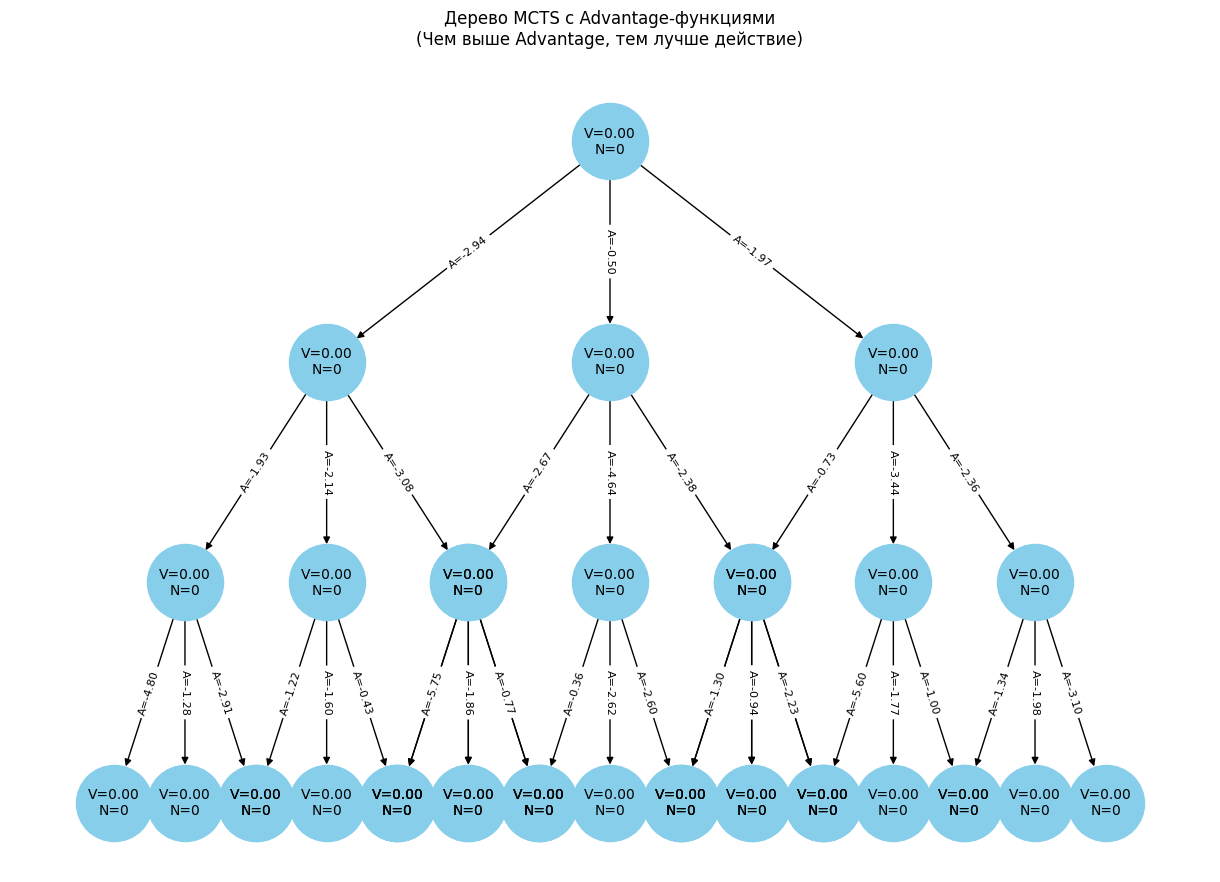

In [18]:
# Инициализация модели
model = APN(state_size=10, action_size=4, layer_size=64, seed=42)

# Корневое состояние
root_state = torch.randn(1, 10)

# Строим дерево MCTS
root = build_mcts_tree(model, root_state, depth=3, n_actions=3)

# Визуализируем
draw_mcts_tree(root)

### **p.s**

Значения V=0.00 и N=0 на всех узлах графа объясняются особенностями демонстрационной реализации алгоритма MCTS в представленном ранее коде.

#### **Причина этого явления:**

1. **Отсутствие симуляции и обратного распространения (backpropagation)**
   
   В классическом алгоритме MCTS есть четыре фазы:
   - Выбор (Selection)
   - Расширение (Expansion)
   - Симуляция (Simulation/Rollout)
   - Обратное распространение (Backpropagation)
   
   В предоставленном коде реализованы только первые две фазы. Функция `build_mcts_tree` строит структуру дерева, но не выполняет симуляций и не обновляет статистику узлов.

2. **Инициализация переменных без обновления**
   
   В коде класса `MCTSNode` переменные инициализируются нулями:
   ```python
   self.visit_count = 0  # N
   self.total_value = 0  # Используется для вычисления V
   ```
   
   А в функции `draw_mcts_tree` для формирования меток используется формула:
   ```python
   labels[node_id] = f"V={node.total_value / (node.visit_count + 1):.2f}\nN={node.visit_count}"
   ```
   
   Так как значения никогда не обновляются, все узлы показывают начальные значения.

3. **Фокус на Advantage, а не на V и N**
   
   Основная цель этого демонстрационного кода - показать использование Advantage-функции для оценки действий (значения на ребрах A=X.XX), а не полноценную работу алгоритма MCTS с обновлением статистики узлов.

В полной реализации MCTS после каждой симуляции `visit_count` должен увеличиваться, а `total_value` - обновляться на основе полученной награды, что привело бы к ненулевым значениям V и N на графе.